[pytimetk for Time Series Analysis in Python](https://medium.com/@kylejones_47003/pytimetk-for-time-series-analysis-in-python-92f725352d99?source=your_stories_page-------------------------------------)
=========================================================================================================================================================================================================

by: Kyle Jones\
published: 2025-01-11

In [16]:
df.head()

,date,values
0,2024-12-29 00:00:13,176.3
1,2024-12-29 00:15:11,172.3
2,2024-12-29 00:30:10,171.2
3,2024-12-29 00:45:11,170.7
4,2024-12-29 01:00:15,167.9


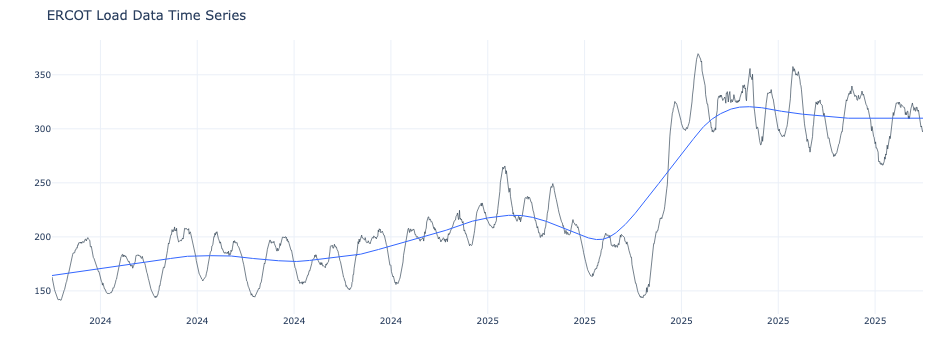

In [95]:
import pandas as pd
import numpy as np
import pytimetk as tk

# Load data
df = pd.read_csv("ercot_load_data.csv")
df['date'] = pd.to_datetime(df['date'])


# Plot the time series using pytimetk's plot_timeseries method
fig = (
    tk.plot_timeseries(
        df,
        date_column='date',
        value_column='values',
        facet_ncol=1,
        x_axis_date_labels="%Y",
        engine='plotly',
        title="ERCOT Load Data Time Series"
    )
)

fig.write_image("time_series_plot.png")
fig.show()

In [85]:
"""
Feature Engineering
Create lagged features, rolling averages, and Fourier terms for machine learning.
"""
import pytimetk as tk
import pandas as pd
import numpy as np


# Feature Engineering
# Add rolling mean and standard deviation for a window of 7 days
rolled_df_7 = tk.augment_rolling_apply(
    df,
    date_column="date",
    window=7,
    window_func=[
        ("rolling_mean_7", lambda x: x["values"].mean()),
        ("rolling_std_7", lambda x: x["values"].std()),
    ],
    center=False,
    threads=1
)

# Add rolling mean and standard deviation for a window of 14 days
rolled_df_14 = tk.augment_rolling_apply(
    rolled_df_7,
    date_column="date",
    window=14,
    window_func=[
        ("rolling_mean_14", lambda x: x["values"].mean()),
        ("rolling_std_14", lambda x: x["values"].std()),
    ],
    center=False,
    threads=1
)

# Add Fourier series for seasonality
rolled_df = tk.augment_fourier(
    rolled_df_14,
    date_column="date",  # Specify the date column
)
rolled_df.tail()

Processing rolling apply...:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rolling apply...:   0%|          | 0/1 [00:00<?, ?it/s]

,date,values,rolling_rolling_mean_7_win_7,rolling_rolling_std_7_win_7,rolling_rolling_mean_14_win_14,rolling_rolling_std_14_win_14,date_sin_1_1,date_cos_1_1
1722,2025-01-10 22:45:11,301.600006,309.928558,5.820858,314.207153,6.048326,-0.549861,0.835256
1723,2025-01-10 23:00:14,302.600006,307.985718,5.645774,313.014282,6.589252,0.970838,0.239736
1724,2025-01-10 23:15:11,301.000000,305.657135,4.384388,311.685699,7.020285,0.164429,-0.986389
1725,2025-01-10 23:30:10,297.299988,303.357147,3.833996,310.328583,7.847433,-1.000000,-0.000535
1726,2025-01-10 23:45:10,298.299988,301.971436,3.623403,309.014282,8.229764,0.206479,0.978451


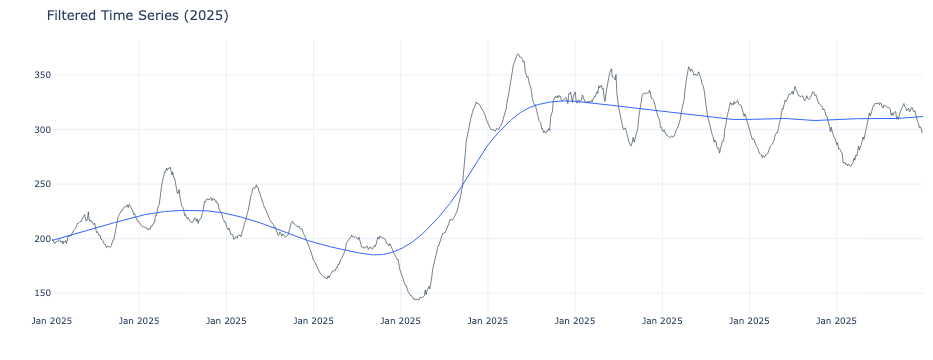

In [87]:
"""
Time-Based Filtering
Filter data for a specific time period.
"""

# Filter data for the year 2021
df_filtered = tk.filter_by_time(
    df,
    date_column="date",
    start_date="2025-01-01"
)

# Plot the filtered data using pytimetk's plot_timeseries method
fig = (
    tk.plot_timeseries(
        df_filtered,
        date_column='date',
        value_column='values',
        facet_ncol=1,
        x_axis_date_labels="%b %Y",  # Adjusted for better visualization within a year
        engine='plotly',
        title="Filtered Time Series (2025)"
    )
)

fig.write_image("filtered_time_series_2025.png")
fig.show()

Processing rolling apply...:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rolling apply...:   0%|          | 0/1 [00:00<?, ?it/s]

                  date      values  values_lag_1  values_lag_2  values_lag_3  \
13 2024-12-24 03:15:11  141.899994    141.800003    143.199997    143.500000   
14 2024-12-24 03:30:11  142.199997    141.899994    141.800003    143.199997   
15 2024-12-24 03:45:11  142.100006    142.199997    141.899994    141.800003   
16 2024-12-24 04:00:12  142.199997    142.100006    142.199997    141.899994   
17 2024-12-24 04:15:10  141.300003    142.199997    142.100006    142.199997   

    rolling_rolling_mean_7_win_7  rolling_rolling_std_7_win_7  \
13                    144.328568                     2.366231   
14                    143.485718                     1.776165   
15                    142.899994                     1.358921   
16                    142.414291                     0.661888   
17                    142.100006                     0.577350   

    rolling_rolling_mean_14_win_14  rolling_rolling_std_14_win_14  \
13                      150.071426                       7.

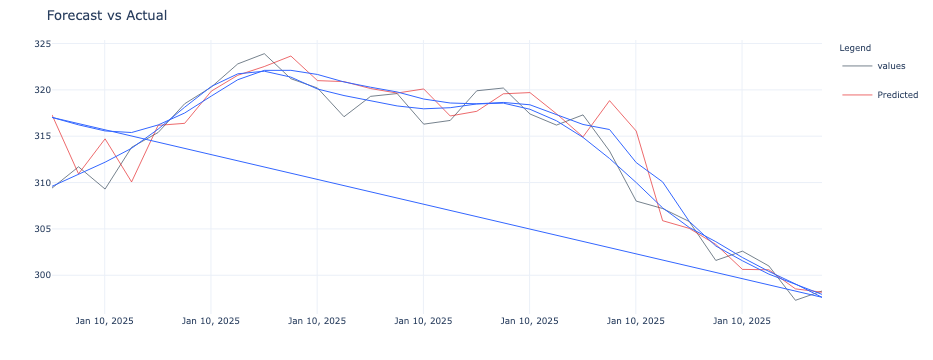

In [89]:
import pandas as pd
import numpy as np
import pytimetk as tk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


df.sort_values(by="date", inplace=True)

# Step 2: Feature Engineering
# Add lagged features for 1, 2, and 3 days
df_features = tk.augment_lags(
    df,
    date_column="date",
    value_column="values",
    lags=[1, 2, 3]
)

# Add rolling mean and standard deviation for 7 and 14 days
df_features = tk.augment_rolling_apply(
    df_features,
    date_column="date",
    window=7,
    window_func=[
        ("rolling_mean_7", lambda x: x["values"].mean()),
        ("rolling_std_7", lambda x: x["values"].std())
    ],
    center=False,
    threads=1
)

df_features = tk.augment_rolling_apply(
    df_features,
    date_column="date",
    window=14,
    window_func=[
        ("rolling_mean_14", lambda x: x["values"].mean()),
        ("rolling_std_14", lambda x: x["values"].std())
    ],
    center=False,
    threads=1
)

# Add Fourier series for seasonality
df_features = tk.augment_fourier(
    df_features,
    date_column="date",  # Specify the date column
)

# Drop rows with NaN values (resulting from lagged features or rolling stats)
df_features = df_features.dropna()

# Verify the resulting DataFrame
print(df_features.head())

# Step 3: Forecast Evaluation
# Split into training and testing sets
train = df_features.iloc[:-30]
test = df_features.iloc[-30:]
# Prepare features and target
X_train = train.drop(columns=["date", "values"])
y_train = train["values"]
X_test = test.drop(columns=["date", "values"])
y_test = test["values"]
# Train the model
model = RandomForestRegressor(random_state=123)
model.fit(X_train, y_train)
# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
# Step 4: Combine Actual and Predicted Values for Plotting
test['Predicted'] = y_pred
# Melt data for pytimetk plotting (long format)
plot_df = test.melt(id_vars="date", value_vars=["values", "Predicted"], 
                    var_name="Series", value_name="Values")
# Plot using pytimetk
fig = tk.plot_timeseries(
    plot_df,
    date_column="date",
    value_column="Values",
    color_column="Series",
    title="Forecast vs Actual",
    x_axis_date_labels="%b %d, %Y",
    engine="plotly"
)
fig.write_image("forecast_vs_actual_plot.png")
fig.show()

In [46]:
plot_df.to_csv("plot.csv")

In [67]:
df.tail()

,date,values
1629,2025-01-10 23:15:11,301.0
382,2025-01-10 23:30:10,297.3
1630,2025-01-10 23:30:10,297.3
383,2025-01-10 23:45:10,298.3
1631,2025-01-10 23:45:10,298.3


In [91]:
from sklearn.ensemble import RandomForestRegressor


train_columns = [ 
    'values'
    ]

X = train[train_columns]
y = train[['Weekly_Sales']]

model = RandomForestRegressor(random_state=123)
model = model.fit(X, y)


Code
predicted_values = model.predict(future[train_columns])
future['y_pred'] = predicted_values

future.head(10)

SyntaxError: invalid syntax (1661628749.py, line 14)

In [49]:
# Ensure indices of predictions and test target match
assert len(y_pred) == len(y_test), "Mismatch in lengths of predictions and actual values."
assert list(test.index) == list(test.index), "Mismatch in indices of predictions and actual values."


In [51]:
# Ensure indices of predictions and test target match
assert len(y_pred) == len(y_test), "Mismatch in lengths of predictions and actual values."
assert list(test.index) == list(test.index), "Mismatch in indices of predictions and actual values."


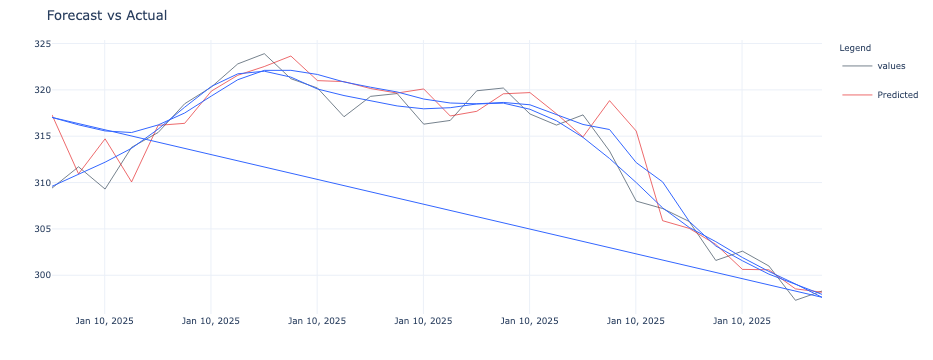

In [93]:
# Adjust plotting for clarity
fig = tk.plot_timeseries(
    plot_df,
    date_column="date",
    value_column="Values",
    color_column="Series",
    title="Forecast vs Actual",
    x_axis_date_labels="%b %d, %Y",
    engine="plotly",
)
fig.show()


In [57]:
from sklearn.linear_model import LinearRegression

# Train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Linear Regression MSE: {mse_lr:.4f}")


Linear Regression MSE: 3.3441


First few test dates: 1697   2025-01-10 16:30:13
1698   2025-01-10 16:45:12
1699   2025-01-10 17:00:12
1700   2025-01-10 17:15:10
1701   2025-01-10 17:30:10
Name: date, dtype: datetime64[ns]
First few prediction dates: Index([1697, 1698, 1699, 1700, 1701], dtype='int64')


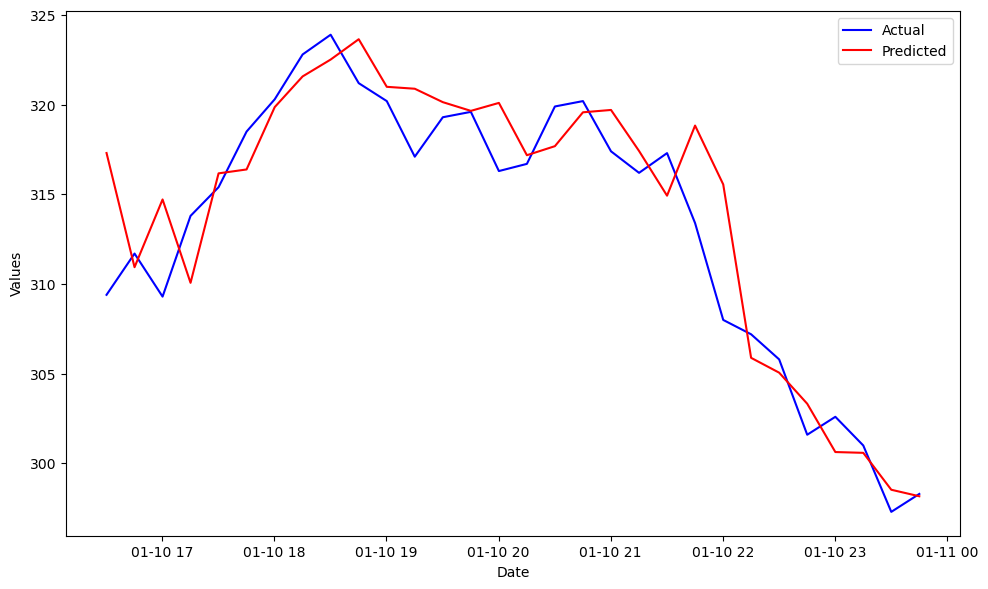

In [99]:
# Check for obvious alignment issues
print(f"First few test dates: {test['date'].head()}")
print(f"First few prediction dates: {test.index[:5]}")

# Plot actual vs predicted in a basic plot to inspect
plt.figure(figsize=(10, 6))
plt.plot(test["date"], y_test, label="Actual", color="Blue")
plt.plot(test["date"], y_pred, label="Predicted", color="Red")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.tight_layout()
plt.savefig("forecast_plot.png")
plt.show()


In [61]:
import matplotlib.pyplot as plt

In [69]:
df.drop_duplicates(inplace=True)

In [71]:
df.shape

(1727, 2)

In [75]:
df.set_index('date', inplace=True)

In [77]:
df.sort_index(inplace=True)

In [79]:
df.head()

,values
date,
2024-12-24 00:00:14,163.0
2024-12-24 00:15:11,160.0
2024-12-24 00:30:11,158.2
2024-12-24 00:45:11,156.0
2024-12-24 01:00:15,152.6


In [81]:
df.to_csv("ercot_load_data.csv")